In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dataset.pendulum as pendulum
import utils.methods as methods
import utils.math_utils as math_utils

## 1. Generate the data

In [2]:
# Random initial conditions
state = [np.random.rand()*np.pi, np.random.rand()*np.pi, np.random.rand()*np.pi, np.random.rand()*np.pi]
t_stop = 40.0

# Data
p = pendulum.Pendulum(t_stop)
data = p.solver(state)
t = np.linspace(0, t_stop, int(t_stop/0.02))

# Animation
#p.ani(state)

## 2. Prepare the data

In [3]:
# Split the dataframe
y_train, y_test, t_train, t_test = methods.split_set(data, t, 0.4)

## 3. Define the models

### Recurrent Neural Network

In [4]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout

# Scale the data
scaler = MinMaxScaler(feature_range = (0, 1))
df_scaled = scaler.fit_transform(data)

# Creamos las secuencias para la red LSTM
def create_sequences(data, n_steps):
    x, y = [], []
    for i in range(len(data) - n_steps):
        x.append(data[i: i +n_steps])
        y.append(data[i + n_steps])
    return np.array(x), np.array(y)

#n_steps = int(0.5*len(data) # Numero de pasos de la secuencia
n_steps = 20
x, y = create_sequences(df_scaled, n_steps)

In [5]:
y.shape, x.shape, data.values.shape

((1980, 4), (1980, 20, 4), (2000, 4))

In [6]:
# Define the LSTM model
model = Sequential()
model.add(SimpleRNN(units = 40, activation = 'tanh', use_bias = True, input_shape=(x.shape[1], x.shape[2])))
model.add(Dropout(0.2))
#model.add(SimpleRNN(units = 200, input_shape=(500, 500, 4)))
#model.add(Dense(10, activation = 'relu'))
"""
model.add(LSTM(units=100, input_shape=(x.shape[1], x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Regularización para prevenir sobreajuste
model.add(LSTM(units=50))
model.add(Dense(10, activation='relu'))  # Capa intermedia
"""
model.add(Dense(4))

model.compile(optimizer = 'adam', loss = 'mse')

model.summary()

C:\Users\Juanjo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 40)             │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,964 (7.67 KB)

 Trainable params: 1,964 (7.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4560 - val_loss: 0.0343
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0741 - val_loss: 0.0323
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0512 - val_loss: 0.0273
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0395 - val_loss: 0.0247
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333 - val_loss: 0.0222
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0302 - val_loss: 0.0218
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0277 - val_loss: 0.0204
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0262 - val_loss: 0.0188
Epoch 9/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0248 - val_loss: 0.0189
Epoch 10/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0229 - val_loss: 0.0182
Epoch 11/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_loss: 0.0183
Epoch 12/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221 - val_lo

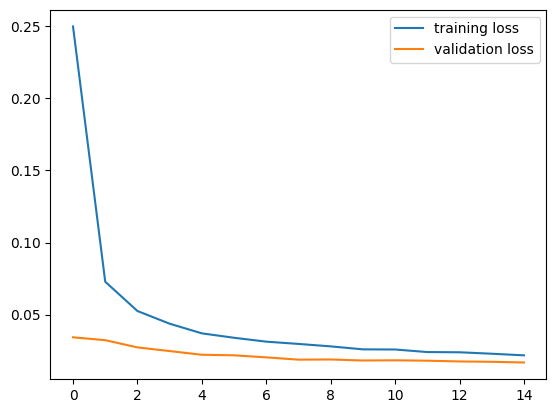

In [7]:
# Reshape for the data
x = x.reshape((x.shape[0], x.shape[1], 4))
y = y.reshape((y.shape[0], 1, y.shape[1]))

# Train the model
history = model.fit(x, y, shuffle = False, epochs = 15, batch_size = 32, validation_split = 0.2, verbose = 1)

# Plot the loss iteration (training and validation)
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [22]:
"""# Hacemos las predicciones
# Usar los últimos n_steps puntos para predecir el siguiente valor
x_input = df_scaled[-n_steps:].reshape((1, n_steps, 4))
#x_input = scaler.fit_transform(y_train)
predicted = model.predict(x_input, verbose=0)

# Invertir la escala para obtener el valor original
predicted = predicted.reshape((n_steps, 4))
predicted_value = scaler.inverse_transform(predicted)
print(f'Predicción del péndulo: {predicted_value[0][0]:.4f}')"""

"# Hacemos las predicciones\n# Usar los últimos n_steps puntos para predecir el siguiente valor\nx_input = df_scaled[-n_steps:].reshape((1, n_steps, 4))\n#x_input = scaler.fit_transform(y_train)\npredicted = model.predict(x_input, verbose=0)\n\n# Invertir la escala para obtener el valor original\npredicted = predicted.reshape((n_steps, 4))\npredicted_value = scaler.inverse_transform(predicted)\nprint(f'Predicción del péndulo: {predicted_value[0][0]:.4f}')"

In [40]:
df_scaled.shape

(1001, 4)

In [49]:
# prediction
df_scaled.shape
y_train_sc = scaler.fit_transform(y_train)
for i in range(len(y_test)):
    x_input = y_train_sc[i:i + n_steps].reshape((1, n_steps, 4))
    predicted = model.predict(x_input, verbose = 0)
    y_train_sc = np.concatenate((y_train_sc, predicted), axis = 0)
data_new = scaler.inverse_transform(y_train_sc)

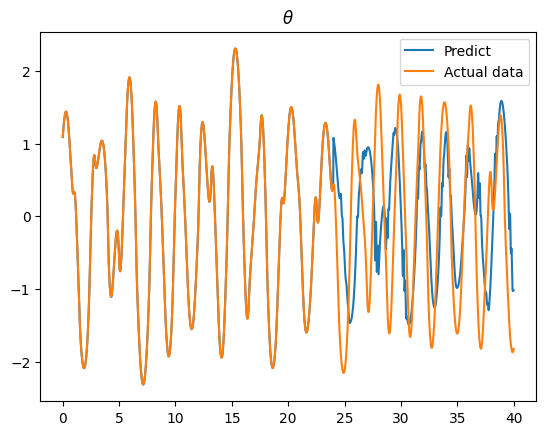

In [54]:
# Representation
#data_new = scaler.inverse_transform(y_train_sc)
k = 0
plt.plot(t, data_new[:, k], label = 'Predict')
plt.plot(t, data.values[:, k], label = r'Actual data')
plt.title(r'$\theta$')
plt.legend()
plt.show()

In [33]:
predicted_value.shape, y_train.shape

((1, 4), (500, 4))

ValueError: x and y must have same first dimension, but have shapes (1000,) and (501,)

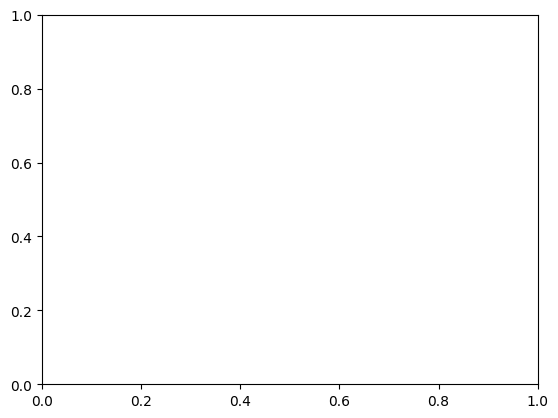

In [97]:
# Concatenate the data
data_new = np.concatenate((y_train, predicted_value), axis = 0)

# Graficar los resultados
plt.plot(t, data_new[:, 0], label = r'Predicted')
plt.plot(t, data.values[:, 0], label = r'Actual data')
#plt.plot(train_predict[:, 5], label = 'Predicciones')
plt.title(r'$\theta$')
#plt.plot(train_predict.reshape((train_predict.shape[0]*train_predict.shape[1])), label = 'Predicciones')
plt.legend()
plt.show()

### LSTM

### Prophet

In [ ]:
import pandas as pd
from prophet import Prophet

# Creamos un DataFrame con los datos de la serie temporal
# Supongamos que tenemos datos de ventas diarias

data = {

    'ds': pd.date_range(start = '2023-01-01', periods = 100, freq = 'D'), 
    'y': [20 + i + (i%5)*5 + 40*np.random.rand() for i in range(100)]
}

df = pd.DataFrame(data)

# Creamos un modelo Prophet
model = Prophet()

# Ajustamos el modelo a los datos
model.fit(df)

# Creamos un DataFrame para las futuras predicciones (por ejemplo, predecir 30 días en el futuro)
future = model.make_future_dataframe(periods = 30)

# Realizamos las predicciones
forecast = model.predict(future)

# Mostramos las predicciones
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Opcional: Graficamos las predicciones
import matplotlib.pyplot as plt

model.plot(forecast)
plt.show()



### VAR

## 4. Represent all the data